In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

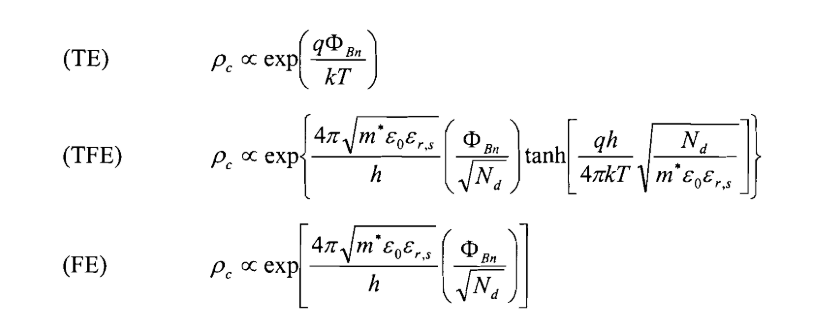

$\rho_{FE} = \frac{k_B sin(c_1k_BT)}{\pi qTA^*} \cdot \exp{\left\{ \frac{q\Phi_B}{E_{00}} \right\}}\\
\text{with} \quad c_1 = \frac{1}{2E_{00}} \cdot \ln{\left( \frac{4(\Phi_B)}{\Phi_n} \right)} $

$\rho_{TFE} = \frac{k_B\sqrt{E_{00}} \cosh{\left(\frac{E_{00}}{k_BT}\right)} \coth{\left(\frac{E_{00}}{k_BT}\right)}}{qTA^* \sqrt{\pi q (\Phi_B-\Phi_n)}} \cdot \exp{\left\{ \frac{q(\Phi_B-\Phi_n)}{E_{00} \coth{\left(\frac{E_{00}}{k_BT}\right)}} + \frac{q\Phi_n}{k_BT}\right\}}$

$\rho_{TE} = \frac{k}{qA^*T} \exp{\left\{ \frac{q\Phi_B}{kT} \right\}}$

In [ ]:
import numpy as np

def calculate_contact_resistivity(
    N_D_plus_cm3: float,
    Phi_B: float,
    T: float = 300.0,
    Nc_cm3: float = 1.7e19,
    epsilon_s: float = 9.7,
    m_star_ratio: float = 0.37,
    A_star_factor: float = 146.0
) -> float:
    """
    Calculates the contact resistivity (rho_K) based on the Thermionic-Field Emission (TFE) 
    approximation, using the formulas provided.
    
    The function uses SI units internally (meter, kilogram, second, Ampere, Kelvin) 
    and returns the resistivity in Ohm*m^2.

    Parameters:
    - N_D_plus_cm3 (float): Net doping concentration (N_D+) in the semiconductor (cm^-3).
    - Phi_B (float): Schottky barrier height (in Volts).
    - T (float): Temperature (in Kelvin). Default is 300 K (Room Temperature).
    - Nc_cm3 (float): Effective density of states in the conduction band (Nc) (cm^-3). 
                      Default is for n-Si at 300K (2.8e19 cm^-3).
    - epsilon_s (float): Relative permittivity (dielectric constant) of the semiconductor. 
                         Default is 11.7 for Silicon.
    - m_star_ratio (float): Ratio of the effective mass (m*) to the free electron mass (m0). 
                            Default is 0.26 for n-Si (density of states mass).
    - A_star_factor (float): Richardson constant (A*) in units of A/cm^2/K^2. 
                             Default is 252 for n-Si.

    Returns:
    - rho_K (float): The contact resistivity in Ohm * m^2.
    """
    
    # ----------------------------------------------------
    # 1. PHYSICAL CONSTANTS (SI Units)
    # ----------------------------------------------------
    q = 1.602176634e-19         # Elementary charge (C)
    k = 1.380649e-23            # Boltzmann constant (J/K)
    h = 6.62607015e-34          # Planck constant (J*s)
    epsilon_0 = 8.8541878128e-12 # Permittivity of free space (F/m)
    m_0 = 9.1093837015e-31      # Free electron rest mass (kg)

    # ----------------------------------------------------
    # 2. INPUT UNIT CONVERSIONS (cm^-3 to m^-3)
    # ----------------------------------------------------
    conversion_factor = 1e6 # 1 m^3 = 10^6 cm^3
    N_D_plus = N_D_plus_cm3 * conversion_factor
    Nc = Nc_cm3 * conversion_factor
    
    # ----------------------------------------------------
    # 3. CALCULATE MATERIAL-DEPENDENT CONSTANTS (SI)
    # ----------------------------------------------------
    m_star = m_star_ratio * m_0 # Effective mass (kg)
    
    # Richardson constant in SI units (A/m^2/K^2). A* factor is in A/cm^2/K^2, so *1e4.
    A_star = A_star_factor * 1e4 
    
    # Total permittivity
    epsilon = epsilon_s * epsilon_0 

    # ----------------------------------------------------
    # 4. CALCULATE Phi_n (Fermi Level Barrier, in Volts)
    #    Phi_n = -(k/q) * T * ln(N/Nc)
    # ----------------------------------------------------
    thermal_voltage = k / q * T
    
    # Guard against non-physical input where N > Nc (degenerate case requires a different formula)
    if N_D_plus >= Nc:
        # In the degenerate case, the formula for Phi_n given by the user is invalid.
        # We will set a small value for the calculation to proceed, but warn the user.
        print(f"Warning: N_D+ ({N_D_plus_cm3} cm^-3) is >= Nc. Using a modified ratio for non-degenerate Phi_n calculation.")
        phi_n = -thermal_voltage * np.log(0.99) # Use a value slightly less than 1
    else:
        phi_n = -thermal_voltage * np.log(N_D_plus / Nc)
    
    # Ensure phi_n is positive for the log argument in c1, as (Ec - Ef)/q is positive for n-type non-degenerate
    # The user's formula definition for phi_n already contains the negative sign. 
    # For the ratio in c1, we need the magnitude (Ec-Ef)/q, which is the magnitude of phi_n.
    Phi_n_mag = abs(phi_n)

    # ----------------------------------------------------
    # 5. CALCULATE E_00 (Characteristic Energy, in Joules)
    #    E_00 = (q * h / 4pi) * sqrt(N_D+ / (eps_s * eps_0 * m*))
    # ----------------------------------------------------
    prefactor = (q * h) / (4 * np.pi)
    sqrt_term = np.sqrt(N_D_plus / (epsilon * m_star))
    E_00 = prefactor * sqrt_term
    
    # ----------------------------------------------------
    # 6. CALCULATE c_1 (Dimensionless argument helper)
    #    c_1 = (1 / 2 E_00) * log(4 * Phi_B / Phi_n)
    # ----------------------------------------------------
    # The argument log(4*Phi_B / Phi_n) is unitless (V/V). 
    # The term 1 / (2 * E_00) must have units of J^-1 for pi * c1 * k * T to be unitless.
    if Phi_n_mag <= 0:
         print("Error: Calculated Phi_n magnitude is non-positive. Cannot calculate c1.")
         return np.nan

    c1 = (1 / (2 * E_00)) * np.log(4 * Phi_B / Phi_n_mag)
    
    # ----------------------------------------------------
    # 7. CALCULATE rho_K (Contact Resistivity, in Ohm*m^2)
    #    rho_K = (k * sin(pi * c1 * k * T) / (pi * q * A* * T)) * exp(q * Phi_B / E_00)
    # ----------------------------------------------------
    
    # Term 1: Exponential Term (unitless)
    exp_term = np.exp((q * Phi_B) / E_00)
    
    # Term 2: Pre-exponential Term (units Ohm*m^2)
    # The argument for sin is pi * c1 * k * T. Since c1 has units J^-1 and k*T has units J,
    # the argument is unitless, which is correct for a sine function.
    sin_arg = np.pi * c1 * k * T
    
    if np.sin(sin_arg) == 0:
        # Avoid division by zero if A_star or T are 0, though T=0 is non-physical
        if A_star == 0 or T == 0:
             return np.nan
        pre_exp_term = 0
    else:
        pre_exp_term = (k * np.sin(sin_arg)) / (np.pi * q * A_star * T)
    
    rho_K = pre_exp_term * exp_term
    
    return rho_K

# # ----------------------------------------------------
# # Example Usage (n-Si example)
# # ----------------------------------------------------

# # Doping concentration for low-resistance contact (highly doped)
# doping_cm3 = 1e19
# # Schottky Barrier Height (e.g., Al on n-Si)
# barrier_height_V = 0.3
# # Temperature
# temperature_K = 300.0

# contact_res = calculate_contact_resistivity(
#     N_D_plus_cm3=doping_cm3,
#     Phi_B=barrier_height_V,
#     T=temperature_K
# )

# print(f"--- Contact Resistivity Calculation ---")
# print(f"Doping (N_D+): {doping_cm3} cm^-3")
# print(f"Barrier Height (Phi_B): {barrier_height_V} V")
# print(f"Temperature (T): {temperature_K} K")
# print(f"\nCalculated Contact Resistivity (rho_K): {contact_res:.2e} Ohm * m^2")
# # Typical values are often given in Ohm*cm^2. To convert to Ohm*cm^2, multiply by 1e4.
# print(f"Calculated Contact Resistivity (rho_K): {contact_res * 1e4:.2e} Ohm * cm^2")

# # Note: The result depends heavily on the accuracy of the coefficients (A*, m*, etc.)
# # and the underlying physical model.

--- Contact Resistivity Calculation ---
Doping (N_D+): 1e+19 cm^-3
Barrier Height (Phi_B): 0.3 V
Temperature (T): 300.0 K

Calculated Contact Resistivity (rho_K): -4.12e-10 Ohm * m^2
Calculated Contact Resistivity (rho_K): -4.12e-06 Ohm * cm^2


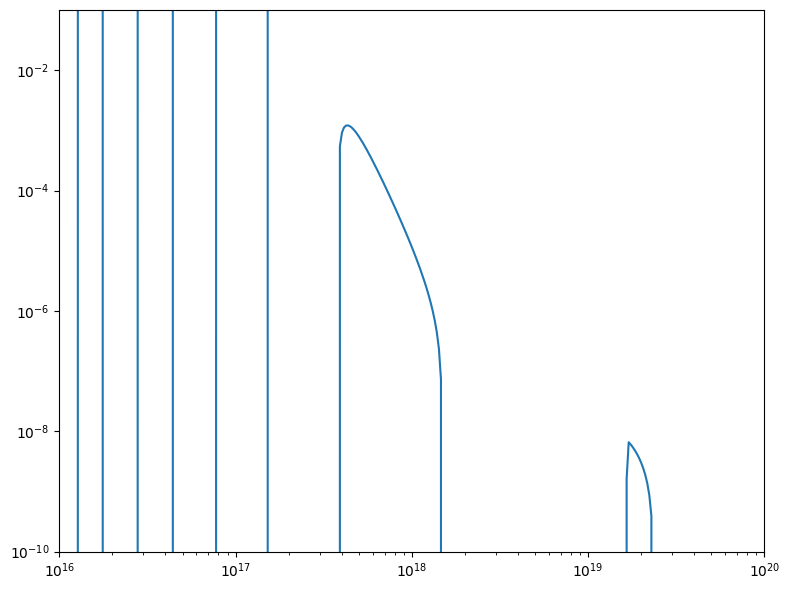

In [27]:

plt.figure(figsize=(8, 6))
N = np.logspace(16, 19.5, 300) 
rho_FE_array = []
for n in N:
    # print(n)
    rho_FE = calculate_contact_resistivity(
        N_D_plus_cm3=n,
        Phi_B=0.1,
        T=300)
    rho_FE_array.extend([rho_FE* 1e4])  # convert to Ohm*cm^2

plt.loglog(N, rho_FE_array)

plt.xlim(1e16, 1e20)
plt.ylim(1e-10, 1e-1)

plt.tight_layout()
plt.show()

<>:156: SyntaxWarning: "\P" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\P"? A raw string is also an option.
<>:156: SyntaxWarning: "\P" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\P"? A raw string is also an option.
C:\Users\lhager\AppData\Local\Temp\ipykernel_2112\1357656558.py:156: SyntaxWarning: "\P" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\P"? A raw string is also an option.
  plt.loglog(N_plot, rho_K_plot, label=f'Canonical FE Model ($\Phi_B={barrier_height_V_plot}$ V)')


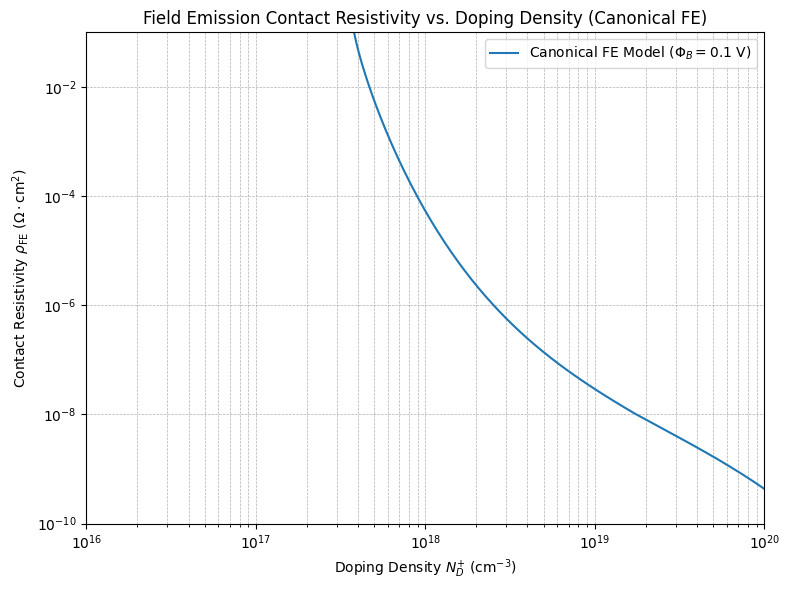

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_contact_resistivity(
    N_D_plus_cm3: float,
    Phi_B: float,
    T: float = 300.0,
    Nc_cm3: float = 1.7e19,
    epsilon_s: float = 9.7,
    m_star_ratio: float = 0.37,
    A_star_factor: float = 146.0
) -> float:
    """
    Calculates the contact resistivity (rho_K) based on the canonical Field Emission (FE) 
    model, which is dominant in highly doped semiconductors (high N_D+).
    
    Formula used:
    rho_FE = [k/(q A* T)] * sqrt[ (pi * E_00) / (q * (Phi_B - Phi_n)) ] * [1 / cosh(E_00 / (k T))] * exp(q * Phi_B / E_00)
    
    The function uses SI units internally (meter, kilogram, second, Ampere, Kelvin) 
    and returns the resistivity in Ohm*m^2.

    Parameters:
    - N_D_plus_cm3 (float): Net doping concentration (N_D+) in the semiconductor (cm^-3).
    - Phi_B (float): Schottky barrier height (in Volts).
    - T (float): Temperature (in Kelvin). Default is 300 K (Room Temperature).
    - Nc_cm3 (float): Effective density of states in the conduction band (Nc) (cm^-3). 
                      Default is 1.7e19 cm^-3 (GaAs).
    - epsilon_s (float): Relative permittivity (dielectric constant) of the semiconductor. 
                         Default is 9.7 (GaAs).
    - m_star_ratio (float): Ratio of the effective mass (m*) to the free electron mass (m0). 
                            Default is 0.37 (GaAs density of states mass).
    - A_star_factor (float): Richardson constant (A*) in units of A/cm^2/K^2. 
                             Default is 146.0 for n-GaAs.

    Returns:
    - rho_K (float): The contact resistivity in Ohm * m^2.
    """
    
    # ----------------------------------------------------
    # 1. PHYSICAL CONSTANTS (SI Units)
    # ----------------------------------------------------
    q = 1.602176634e-19         # Elementary charge (C)
    k = 1.380649e-23            # Boltzmann constant (J/K)
    h = 6.62607015e-34          # Planck constant (J*s)
    epsilon_0 = 8.8541878128e-12 # Permittivity of free space (F/m)
    m_0 = 9.1093837015e-31      # Free electron rest mass (kg)

    # ----------------------------------------------------
    # 2. INPUT UNIT CONVERSIONS (cm^-3 to m^-3)
    # ----------------------------------------------------
    conversion_factor = 1e6 # 1 m^3 = 10^6 cm^3
    N_D_plus = N_D_plus_cm3 * conversion_factor
    Nc = Nc_cm3 * conversion_factor
    
    # ----------------------------------------------------
    # 3. CALCULATE MATERIAL-DEPENDENT CONSTANTS (SI)
    # ----------------------------------------------------
    m_star = m_star_ratio * m_0 # Effective mass (kg)
    
    # Richardson constant in SI units (A/m^2/K^2). A* factor is in A/cm^2/K^2, so *1e4.
    A_star = A_star_factor * 1e4 
    
    # Total permittivity
    epsilon = epsilon_s * epsilon_0 

    # ----------------------------------------------------
    # 4. CALCULATE Phi_n (Fermi Level Barrier, in Volts)
    #    Phi_n = -(k/q) * T * ln(N/Nc) 
    # ----------------------------------------------------
    thermal_voltage_V = k / q * T
    
    if N_D_plus >= Nc:
        # For degenerate case, E_c - E_f < 0. Phi_n should be 0 or negative. 
        # For the sqrt(Phi_B - Phi_n) term in the denominator, we approximate Phi_n = 0.
        Phi_n_V = 0.0 
    else:
        phi_n = -thermal_voltage_V * np.log(N_D_plus / Nc)
        # Phi_n (Ec - Ef)/q is positive for non-degenerate n-type.
        Phi_n_V = abs(phi_n)

    # ----------------------------------------------------
    # 5. CALCULATE E_00 (Characteristic Energy, in Joules)
    #    E_00 = (q * h / 4pi) * sqrt(N_D+ / (eps_s * eps_0 * m*))
    # ----------------------------------------------------
    prefactor_E00 = (q * h) / (4 * np.pi)
    sqrt_term = np.sqrt(N_D_plus / (epsilon * m_star))
    E_00 = prefactor_E00 * sqrt_term # E_00 in Joules
    
    if E_00 == 0:
        return np.nan
    
    # Check for non-physical parameters in the square root
    if Phi_B - Phi_n_V <= 0:
        print(f"Warning: Phi_B ({Phi_B} V) <= Phi_n ({Phi_n_V:.2e} V). FE formula invalid for this condition.")
        return np.nan

    # ----------------------------------------------------
    # 6. CALCULATE rho_FE (Field Emission Resistivity, in Ohm*m^2)
    # 
    # Formula: rho_FE = [k/(q A* T)] * sqrt[ (pi * E_00) / (q * (Phi_B - Phi_n)) ] * [1 / cosh(E_00 / (k T))] * exp(q * Phi_B / E_00)
    # ----------------------------------------------------
    
    # Term 1: Pre-factor [k / (q A* T)]
    pre_factor = k / (q * A_star * T)
    
    # Term 2: Square Root Term (unitless)
    # (E_00 is in J. q*Phi_B is in J. The ratio is unitless.)
    sqrt_term_fe = np.sqrt((np.pi * E_00) / (q * (Phi_B - Phi_n_V)))
    
    # Term 3: cosh Term (unitless)
    cosh_arg = E_00 / (k * T) # J / J = unitless
    cosh_term = 1.0 / np.cosh(cosh_arg)
    
    # Term 4: Exponential Tunneling Factor (unitless)
    exp_term = np.exp((q * Phi_B) / E_00) # J / J = unitless
    
    rho_FE = pre_factor * sqrt_term_fe * cosh_term * exp_term
    
    return rho_FE

# ----------------------------------------------------
# Example Usage (n-GaAs example)
# ----------------------------------------------------

try:
    # Doping concentrations from 1e16 to 1e20 cm^-3 (logarithmic sweep)
    N = np.logspace(16, 20, 300) 
    barrier_height_V_plot = 0.1 # Example plot uses 0.1 V
    temperature_K = 300.0
    
    rho_K_array = []
    
    for n in N:
        # Calculate resistivity using the canonical FE formula
        rho_K_m2 = calculate_contact_resistivity(
            N_D_plus_cm3=n,
            Phi_B=barrier_height_V_plot,
            T=temperature_K
        )
        rho_K_cm2 = rho_K_m2 * 1e4
        rho_K_array.append(rho_K_cm2)
    
    # Prepare data for plotting
    N_clean = np.array(N)
    rho_K_clean = np.array(rho_K_array)
    valid_indices = np.isfinite(rho_K_clean) & (rho_K_clean > 1e-30)
    
    N_plot = N_clean[valid_indices]
    rho_K_plot = rho_K_clean[valid_indices]

    # Initialize Plot
    plt.figure(figsize=(8, 6))
    
    # Plotting the data
    plt.loglog(N_plot, rho_K_plot, label=f'Canonical FE Model ($\Phi_B={barrier_height_V_plot}$ V)')

    # Plot Settings to match typical literature
    plt.xlabel('Doping Density $N_D^{+}$ $(\\text{cm}^{-3})$')
    plt.ylabel('Contact Resistivity $\\rho_{\\text{FE}}$ $(\\Omega \\cdot \\text{cm}^2)$')
    plt.title('Field Emission Contact Resistivity vs. Doping Density (Canonical FE)')
    plt.grid(True, which="both", ls="--", linewidth=0.5)
    
    plt.xlim(1e16, 1e20)
    plt.ylim(1e-10, 1e-1)
    
    plt.legend()
    plt.tight_layout()
    plt.show()

except Exception as e:
    # Simple check for plotting errors
    print(f"An error occurred during plotting: {e}")
    print("\n--- Stable Calculation Check (No Plot) ---")
    doping_cm3_test = 1e19
    contact_res_test = calculate_contact_resistivity(doping_cm3_test, 0.3)
    print(f"Doping: {doping_cm3_test:.2e} cm^-3 -> rho_K: {contact_res_test * 1e4:.2e} Ohm*cm^2")